In [10]:
import numpy as np, matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from palettable.colorbrewer.qualitative import Set1_9
import os
from datetime import datetime
from IPython.display import HTML
import itertools


pwd = os.path.abspath('') + "/"
print(pwd)

c:\Users\Jonathan.Reasoner\Documents\active_inference_playground\aif_multi_robot\archive/


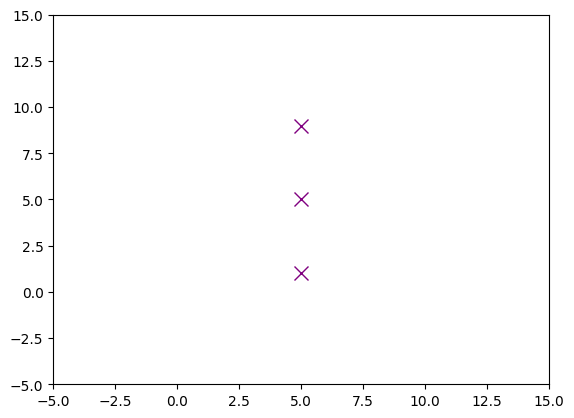

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import to_rgba_array
import itertools

# Environment and simulation parameters
cmap = to_rgba_array(['tab:blue', 'tab:orange', 'tab:green'])
goals = np.array([[5, 1], [5, 5], [5, 9]], dtype=float)  # Goal positions
initial_agent_positions = np.array([[1, 1], [1, 5], [1, 9]], dtype=float)  # Initial agent positions
num_agents = initial_agent_positions.shape[0]  # Number of agents
velocity_options = [0, 0.1, 0.5, 1.0]  # Velocity options for the agents
heading_options = np.linspace(-np.pi, np.pi, 12)  # Heading options (radians)
observation_error_std = 3.0  # Observation noise standard deviation
max_iterations = 100  # Maximum number of iterations

# Initialize figure for plotting
fig, ax = plt.subplots()
plt.xlim(-5, 15)
plt.ylim(-5, 15)

# Paths (with smaller line width)
agent_paths = [ax.plot([], [], 'o-', markersize=3, linewidth=1, alpha=0.5, color=cmap[i])[0] for i in range(num_agents)]
# Current positions (with larger markers)
agent_markers = [ax.plot([], [], 'o', markersize=10, color=cmap[i])[0] for i in range(num_agents)]
goal_plots = [ax.plot(goal[0], goal[1], 'x', markersize=10, color='purple')[0] for goal in goals]  # Plot goals

# Global variable to keep track of agent positions during animation
current_positions = np.copy(initial_agent_positions)

def init():
    """Initialize the background of the plot."""
    for agent_path, agent_marker in zip(agent_paths, agent_markers):
        agent_path.set_data([], [])
        agent_marker.set_data([], [])
    return agent_paths + agent_markers + goal_plots

def simulate_observation(true_position):
    """Simulate noisy observation of another agent's position."""
    observed_position = true_position + np.random.normal(0, observation_error_std, true_position.shape)
    return observed_position

def predict_agent_position(agent_position, velocity, heading):
    """Predict agent's next position based on chosen velocity and heading."""
    dx = velocity * np.cos(heading)
    dy = velocity * np.sin(heading)
    return agent_position + np.array([dx, dy])

def make_decision(agent_id, agent_positions):
    """Agent decision-making based on active inference to encourage convergence on a shared goal."""
    best_action = None
    best_score = np.inf

    observed_positions_array = np.zeros((num_agents, 2))
    for i in range(num_agents):
        observed_positions_array[i] = simulate_observation(agent_positions[i])
    
    distance_measurement_array = np.zeros((num_agents, len(goals)))
    for i in range(num_agents):
        for j in range(len(goals)):
            distance_measurement_array[i, j] = np.linalg.norm(observed_positions_array[i] - goals[j])
    
    permutations = itertools.permutations(range(len(goals)))
    min_total_distance = float('inf')
    best_permutation = None

    for perm in permutations:
        total_distance = sum(distance_measurement_array[i, perm[i]] for i in range(num_agents))
        if total_distance < min_total_distance:
            min_total_distance = total_distance
            best_permutation = perm

    goal = best_permutation[agent_id]
    goal_location = goals[goal]
  
    goal_scores = []

    for velocity in velocity_options:
        for heading in heading_options:
            predicted_position = predict_agent_position(agent_positions[agent_id], velocity, heading)
            distance_to_goal = np.linalg.norm(predicted_position - goal_location)
            goal_alignment_score = distance_to_goal
            goal_scores.append((goal_alignment_score, velocity, heading))

    best_action_for_goal = min(goal_scores, key=lambda x: x[0])

    if best_action_for_goal[0] < best_score:
        best_score = best_action_for_goal[0]
        best_action = best_action_for_goal[1], best_action_for_goal[2]

    return best_action

def update(frame):
    """Update the plot for each frame."""
    global current_positions
    decisions = [make_decision(agent_id, current_positions) for agent_id in range(num_agents)]
    
    # Update positions based on decisions
    for agent_id, (velocity, heading) in enumerate(decisions):
        dx = velocity * np.cos(heading)
        dy = velocity * np.sin(heading)
        current_positions[agent_id] += np.array([dx, dy])
    
    # Update plot data
    for agent_id, (agent_path, agent_marker) in enumerate(zip(agent_paths, agent_markers)):
        xdata, ydata = agent_path.get_data()
        xnew, ynew = current_positions[agent_id]
        xdata = np.append(xdata, xnew)
        ydata = np.append(ydata, ynew)
        agent_path.set_data(xdata, ydata)
        agent_marker.set_data(xnew, ynew)
    
    return agent_paths + agent_markers + goal_plots

# Create animation
ani = FuncAnimation(fig, update, frames=max_iterations, init_func=init, blit=True, repeat=False)
plt.show()
